In [3]:
%matplotlib inline
from cosmocalc import cosmocalc
from pylab import *
import pystan
import triangle as tri
import wl_likelihood as wl

In [4]:
def rel_err(x, truth):
    return (x-truth)/abs(truth)

In [5]:
mu = array([log(1e14), log(3)])
smm = square(log(3))
scc = square(log(1.5))
smc = -0.3*sqrt(smm*scc)
sigma = array([[smm, smc], [smc, scc]])

In [15]:
N = 25
Nr = 5
Om = 0.28
Ol = 0.72
h = 0.7
H0 = 100*h
log_cl_params = multivariate_normal(mu, sigma, size=N)
rs = exp(linspace(log(0.1), log(2), Nr))
zl = 0.3
zs = 1.0
dL = cosmocalc(zl, H0, Om, Ol)['DA_Mpc']
dS = cosmocalc(zs, H0, Om, Ol)['DA_Mpc']
dLS = (dS*(1+zs) - dL*(1+zl))/(1+zs)
true_kappas = array([wl.NFW(rs, exp(lm), exp(lc), zl, zs) for lm, lc in log_cl_params])
sigma_kappas = 0.01 + 0*true_kappas
meas_kappas = normal(true_kappas, sigma_kappas)

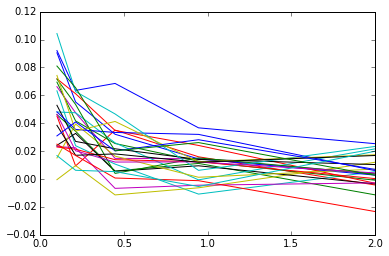

In [16]:
for tk in meas_kappas:
    plot(rs, tk)

In [17]:
data = {'Nr' : Nr,
        'Nc' : N,
        'rs' : rs,
        'kappas': meas_kappas,
        'sigma_kappas' : sigma_kappas,
        'zls': zl + zeros(N),
        'zss': zs + zeros(N),
        'dlss': dLS + zeros(N),
        'dls': dL + zeros(N),
        'dss': dS + zeros(N), 
       'mu0' : array([log(1e14), log(3)]),
       'sigma0' : array([log(10), log(2)])}
init = ({'mu' : mu,
        'sigma' : sigma,
        'log_cl_params' : log_cl_params}, )*4
fit = pystan.stan(file='wl_hierarchical.stan', data=data, init=init)

/Applications/Canopy.app/appdata/canopy-1.5.0.2717.macosx-x86_64/Canopy.app/Contents/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Applications/Canopy.app/appdata/canopy-1.5.0.2717.macosx-x86_64/Canopy.app/Contents/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Applications/Canopy.app/appdata/canopy-1.5.0.2717.macosx-x86_64/Canopy.app/Contents/lib/python2.7/multiprocessing/queues.py:390: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled 

In [18]:
fit

Inference for Stan model: anon_model_9e190f2c50ccb17531e12fbef8002409.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]                 31.8    0.01   0.35  31.11  31.56   31.8  32.03  32.47 1083.0    1.0
mu[1]                 1.27  7.3e-3    0.2   0.87   1.14   1.27    1.4   1.68  778.0    1.0
sigma[0,0]            2.15    0.02    0.7   0.93   1.63   2.11    2.6   3.61 1016.0    1.0
sigma[1,0]           -0.57    0.02   0.42  -1.45  -0.83  -0.52  -0.28   0.12  674.0    1.0
sigma[0,1]           -0.57    0.02   0.42  -1.45  -0.83  -0.52  -0.28   0.12  674.0    1.0
sigma[1,1]            0.42    0.01   0.28   0.07   0.22   0.35   0.54   1.14  590.0    1.0
log_cl_params[0,0]   34.27    0.01   0.46   33.4  33.96  34.26  34.56  35.22 1112.0    1.0
log_cl_params[1,0]   31.37    0.02   0.59  30.21  30.98  31.37  31.75  32.52 1334.0

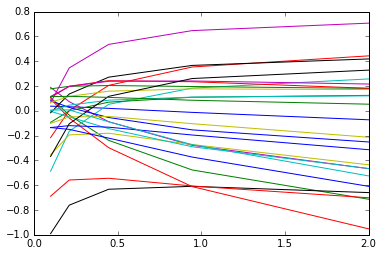

In [19]:
samples = fit.extract(permuted=True)
for i in range(N):
    plot(rs, (true_kappas[i,:] - mean(samples['model_kappas'][:, i, :], axis=0))/true_kappas[i,:])

Quantiles:
[(0.05, 31.212141956109178), (0.95, 32.374659091907773)]
Quantiles:
[(0.05, 0.9486434020895097), (0.95, 1.610820517574874)]
Quantiles:
[(0.05, 1.0897072922149684), (0.95, 3.333802936348488)]
Quantiles:
[(0.05, -1.2917844474875473), (0.95, 0.017188868881942324)]
Quantiles:
[(0.05, 0.10062158837804731), (0.95, 0.94506815289441326)]


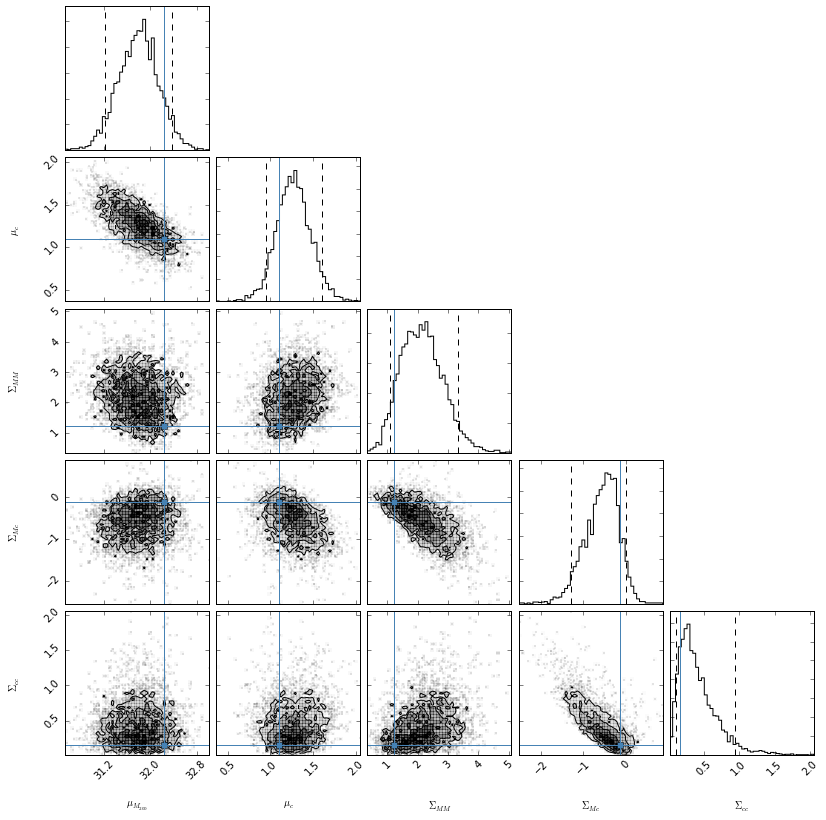

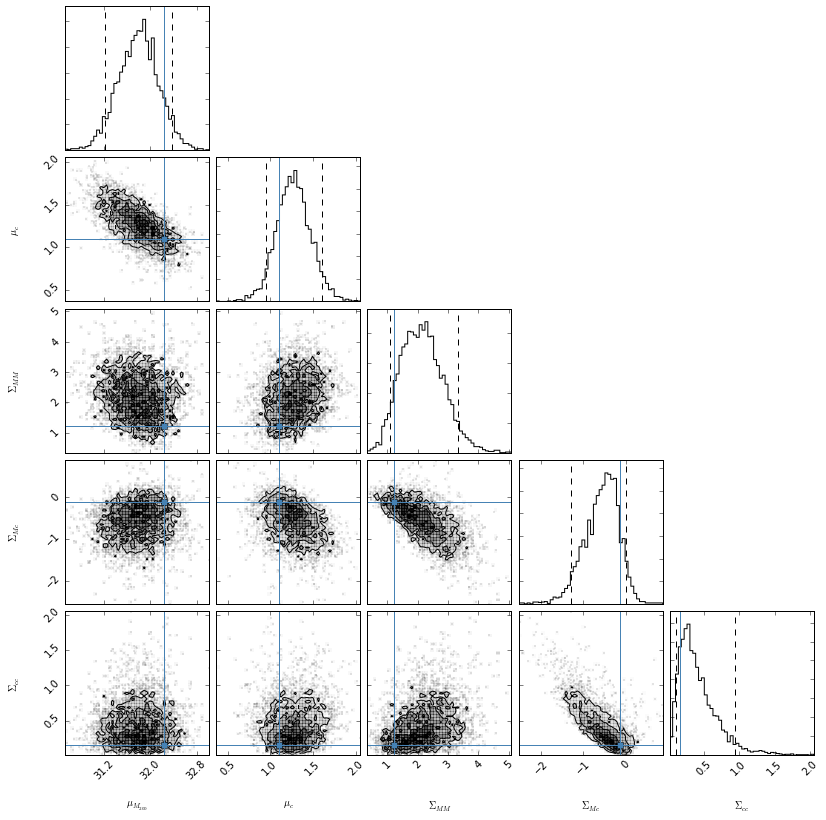

In [20]:
tri.corner(column_stack((samples['mu'].reshape((-1, 2)), samples['sigma'][:, 0,0], samples['sigma'][:, 0, 1], samples['sigma'][:, 1, 1])), truths=concatenate((mu, [smm, smc, scc])), quantiles=[0.05, 0.95], labels=[r'$\mu_{M_{200}}$', r'$\mu_c$', r'$\Sigma_{MM}$', r'$\Sigma_{Mc}$', r'$\Sigma_{cc}$'])

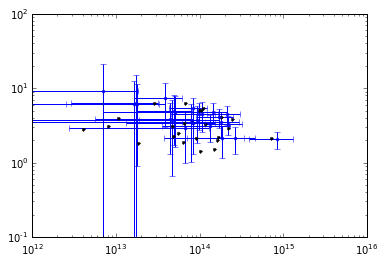

In [21]:
plot(exp(log_cl_params[:,0]), exp(log_cl_params[:,1]), '.k')
errorbar(mean(samples['cl_params'][:,:,0], axis=0), mean(samples['cl_params'][:,:,1], axis=0), xerr=std(samples['cl_params'][:,:,0], axis=0), yerr=std(samples['cl_params'][:,:,1], axis=0), color='b', fmt='.')
xscale('log')
yscale('log')

Quantiles:
[(0.05, 39932028420479.258), (0.95, 214786441225429.0)]
Quantiles:
[(0.05, 2.4344458920535859), (0.95, 7.6900242452216778)]


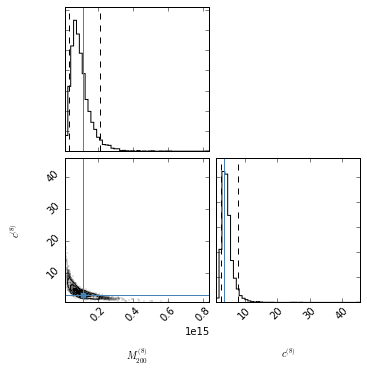

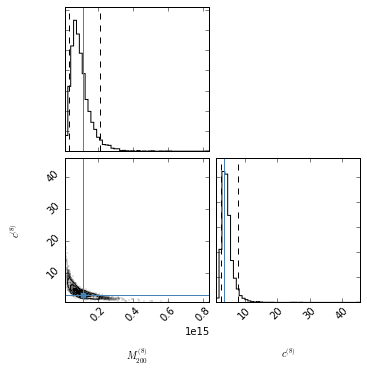

In [22]:
tri.corner(samples['cl_params'][:,8,:], truths=exp(log_cl_params[8,:]), quantiles=[0.05, 0.95], labels=[r'$M_{200}^{(8)}$', r'$c^{(8)}$'])

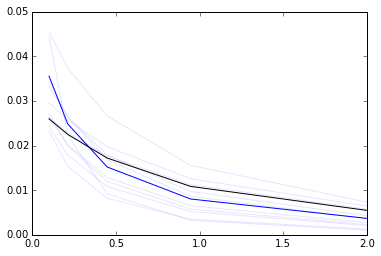

In [24]:
plot(rs, mean(samples['model_kappas'][:,20,:], axis=0), '-b')
for mks in permutation(samples['model_kappas'][:,20,:])[:10]:
    plot(rs, mks, '-b', alpha=0.1)
plot(rs, true_kappas[20,:], '-k')